<a href="https://www.kaggle.com/code/mdsayebgub/xception-lstm-after-preprocessing?scriptVersionId=248180344" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.layers import TimeDistributed, Dropout, Flatten, Dense, LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import gc
import warnings
warnings.filterwarnings('ignore')


2025-06-30 17:01:09.508105: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751302869.771617      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751302869.843975      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Define classes
classes = ["Basketball", "Diving", "HorseRace", "JumpRope", "VolleyballSpiking"]

In [3]:
# Check dataset balance
for class_name in classes:
    files = os.listdir(f'/kaggle/input/realistic-action-recognition-ucf50/UCF50/{class_name}')
    print(f"{class_name}: {len(files)} videos")


Basketball: 137 videos
Diving: 153 videos
HorseRace: 127 videos
JumpRope: 148 videos
VolleyballSpiking: 116 videos


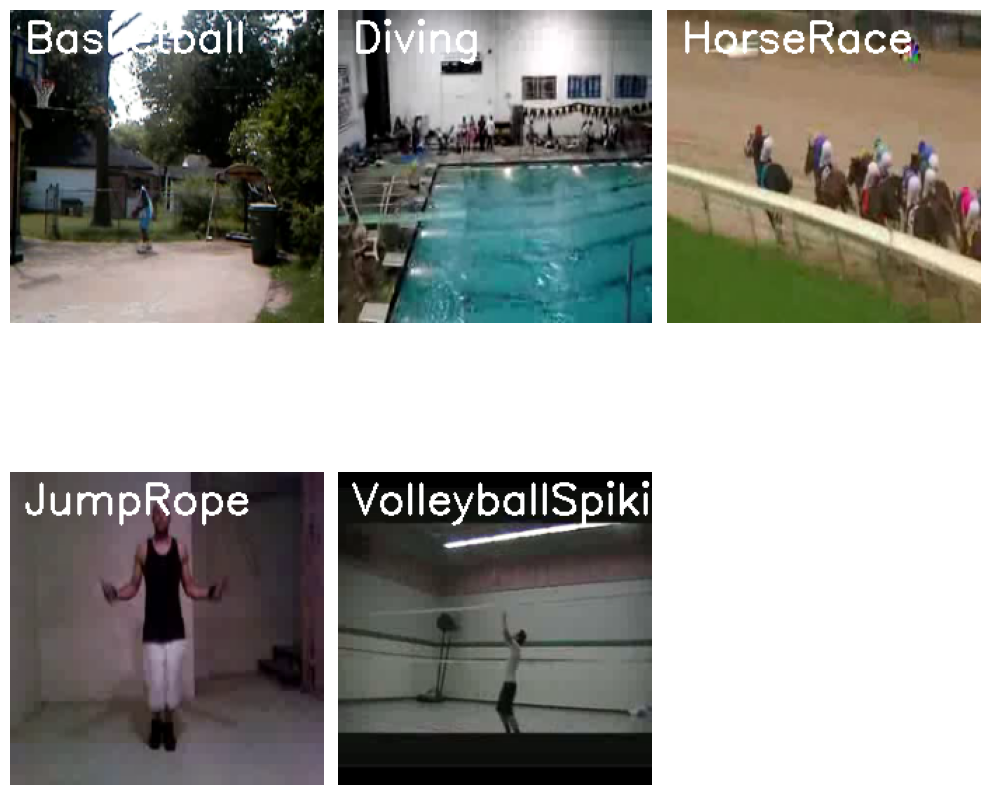

In [8]:
# Visualize sample frames (corrected path)
plt.figure(figsize=(10, 10))
for counter, selected_class_name in enumerate(classes, 1):
    video_files_names_list = os.listdir(f'/kaggle/input/realistic-action-recognition-ucf50/UCF50/{selected_class_name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'/kaggle/input/realistic-action-recognition-ucf50/UCF50/{selected_class_name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    if bgr_frame is None:
        logging.warning(f"Failed to read frame from {selected_class_name}/{selected_video_file_name}")
        continue
    bgr_frame = cv2.resize(bgr_frame, (224, 224))
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, counter)
    plt.imshow(rgb_frame)
    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.imshow(rgb_frame)
    plt.axis('off')
plt.tight_layout()
plt.show()

sequence_length = 15

In [9]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [10]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)
    for frame_counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        frame = cv2.resize(frame, (224, 224))  # Resize early to save memory
        frames_list.append(frame)
    video_reader.release()
    return frames_list

In [11]:
def create_dataset_generator():
    features = []
    labels = []
    for class_name in classes:
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join('/kaggle/input/realistic-action-recognition-ucf50/UCF50', class_name))
        random.shuffle(files_list)  # Shuffle for randomness
        for file_name in files_list:
            video_file_path = os.path.join('/kaggle/input/realistic-action-recognition-ucf50/UCF50', class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == sequence_length:
                features.append(frames)
                labels.append(class_name)
                # Yield in batches to save memory
                if len(features) >= 50:  # Adjust batch size based on memory constraints
                    features = np.array(features, dtype=np.float32)
                    labels = np.array(labels)
                    yield features, labels
                    features, labels = [], []
                    gc.collect()  # Force garbage collection
    if features:  # Yield remaining data
        features = np.array(features, dtype=np.float32)
        labels = np.array(labels)
        yield features, labels
    gc.collect()

In [12]:
# Collect dataset in batches
X, y = [], []
for batch_features, batch_labels in create_dataset_generator():
    # Per-channel normalization
    batch_features = batch_features.astype(np.float32)
    mean = np.mean(batch_features, axis=(0, 1, 2, 3), keepdims=True)
    std = np.std(batch_features, axis=(0, 1, 2, 3), keepdims=True)
    batch_features -= mean
    batch_features /= (std + 1e-7)  # Avoid division by zero
    X.append(batch_features)
    y.append(batch_labels)
    gc.collect()

Extracting Data of Class: Basketball
Extracting Data of Class: Diving
Extracting Data of Class: HorseRace
Extracting Data of Class: JumpRope
Extracting Data of Class: VolleyballSpiking


In [13]:
X = np.concatenate(X, axis=0)
y = np.concatenate(y, axis=0)
print("X shape:", X.shape)

X shape: (681, 15, 224, 224, 3)


In [14]:
# Save mean and std for testing
np.save("mean.npy", mean)
np.save("std.npy", std)


In [15]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)
for label in np.unique(y):
    print(f"{label}: {encoder.inverse_transform([label])[0]}")

0: Basketball
1: Diving
2: HorseRace
3: JumpRope
4: VolleyballSpiking


In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
del X, y
gc.collect()

0

In [17]:
# Load Xception model
xception = Xception(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in xception.layers[:-10]:  # Freeze all but last 10 layers
    layer.trainable = False

In [18]:
# Build model
model = Sequential([
    TimeDistributed(xception, input_shape=(sequence_length, 224, 224, 3), name="Xception"),
    TimeDistributed(Flatten(), name="Flatten"),
    LSTM(256, activation="relu", return_sequences=False, dropout=0.3),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(5, activation="softmax")
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
plot_model(model, show_layer_names=True, dpi=100)

# Callbacks
es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6, verbose=1)

In [19]:
# Generator for training to save memory
def data_generator(x_data, y_data, batch_size, datagen):
    num_samples = len(x_data)
    indices = np.arange(num_samples)
    while True:
        np.random.shuffle(indices)
        for start in range(0, num_samples, batch_size):
            end = min(start + batch_size, num_samples)
            batch_indices = indices[start:end]
            batch_x = x_data[batch_indices]
            batch_y = y_data[batch_indices]
            for i in range(len(batch_x)):
                for j in range(sequence_length):
                    batch_x[i, j] = datagen.random_transform(batch_x[i, j])
            yield batch_x, batch_y

In [20]:
batch_size = 5
train_generator = data_generator(x_train, y_train, batch_size, datagen)
steps_per_epoch = len(x_train) // batch_size

history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50,
    validation_data=(x_test, y_test),
    callbacks=[es, lr_scheduler],
    verbose=1
)


Epoch 1/50


I0000 00:00:1751303175.869381     110 service.cc:148] XLA service 0x2ccd2f00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751303175.870322     110 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751303188.385011     110 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751303204.481109     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


108/108 ━━━━━━━━━━━━━━━━━━━━ 239s 1s/step - accuracy: 0.2204 - loss: 343.7242 - val_accuracy: 0.3212 - val_loss: 26.6250 - learning_rate: 0.0010
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 113s 825ms/step - accuracy: 0.1975 - loss: 172.3013 - val_accuracy: 0.3212 - val_loss: 16.4258 - learning_rate: 0.0010
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 91s 843ms/step - accuracy: 0.2531 - loss: 38.7665 - val_accuracy: 0.3285 - val_loss: 5.9521 - learning_rate: 0.0010
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 87s 807ms/step - accuracy: 0.2842 - loss: 5.3739 - val_accuracy: 0.3723 - val_loss: 1.5969 - learning_rate: 0.0010
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 84s 778ms/step - accuracy: 0.2732 - loss: 1.7063 - val_accuracy: 0.4818 - val_loss: 1.5430 - learning_rate: 0.0010
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 84s 781ms/step - accuracy: 0.2436 - loss: 1.7034 - val_accuracy: 0.3650 - val_loss: 1.3934 - learning_rate: 0.0010
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 83s 773ms/step - accuracy: 0.2369 -

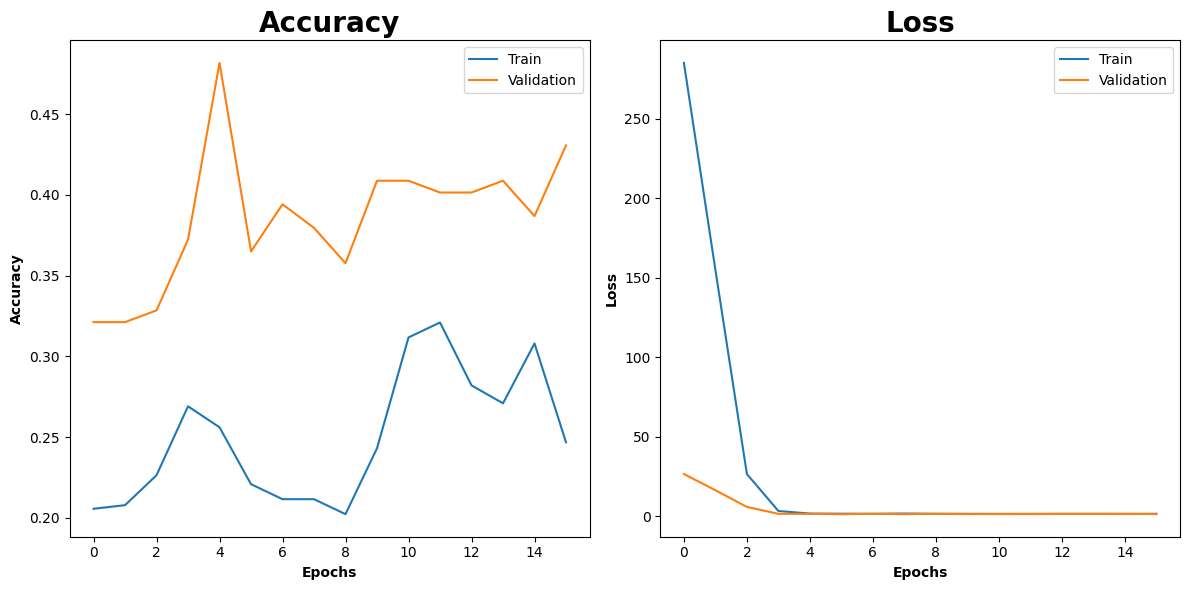

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Accuracy", weight="bold", fontsize=20)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epochs", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.subplot(1, 2, 2)
plt.title("Loss", weight="bold", fontsize=20)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["Train", "Validation"])
plt.xlabel("Epochs", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.tight_layout()
plt.show()

In [22]:
# Evaluate model
prediction = model.predict(x_test, batch_size=5)
y_hat = np.argmax(prediction, axis=1)

28/28 ━━━━━━━━━━━━━━━━━━━━ 62s 1s/step 


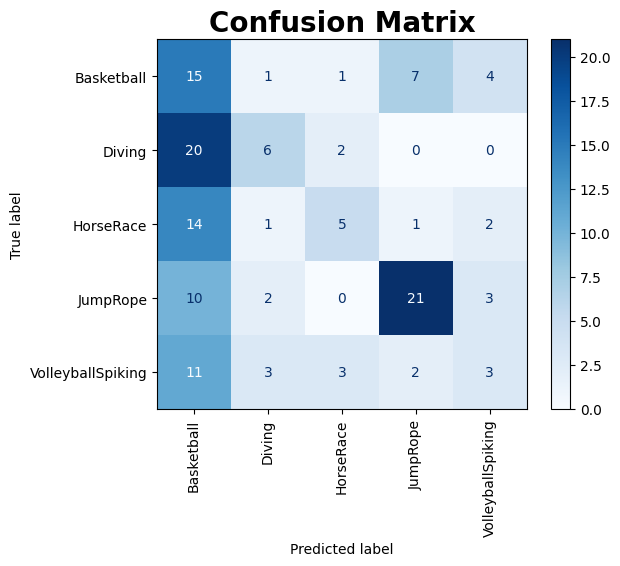

In [23]:
matrix = confusion_matrix(y_test, y_hat)
figure = ConfusionMatrixDisplay(matrix, display_labels=classes)
figure.plot(cmap="Blues")
plt.title("Confusion Matrix", fontsize=20, weight="bold")
plt.xticks(rotation=90)
plt.show()


In [24]:
report = classification_report(y_test, y_hat, target_names=classes)
print(report)

                   precision    recall  f1-score   support

       Basketball       0.21      0.54      0.31        28
           Diving       0.46      0.21      0.29        28
        HorseRace       0.45      0.22      0.29        23
         JumpRope       0.68      0.58      0.63        36
VolleyballSpiking       0.25      0.14      0.18        22

         accuracy                           0.36       137
        macro avg       0.41      0.34      0.34       137
     weighted avg       0.43      0.36      0.36       137



In [25]:
model.save("human_activity_xception_optimized.h5")

In [28]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import os
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

classes = ["Basketball", "Diving", "HorseRace", "JumpRope", "VolleyballSpiking"]
encoder = LabelEncoder()
encoder.fit(classes)
sequence_length = 15

# Load mean and std
mean = np.squeeze(np.load("mean.npy"))  # Remove batch dimension
std = np.squeeze(np.load("std.npy"))    # Remove batch dimension
logging.info(f"Mean shape: {mean.shape}, Std shape: {std.shape}")

model = load_model("human_activity_xception_optimized.h5")
logging.info("Model loaded successfully")

def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        logging.error(f"Failed to open video: {video_path}")
        raise ValueError(f"Cannot open video file: {video_path}")
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count / sequence_length), 1)
    for frame_counter in range(sequence_length):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read()
        if not success:
            break
        frame = cv2.resize(frame, (224, 224))
        frames_list.append(frame)
    video_reader.release()
    return frames_list

def test_model_and_generate_video(input_video_path, output_video_path, mean, std):
    logging.info(f"Processing video: {input_video_path}")
    frames = frames_extraction(input_video_path)
    if len(frames) != sequence_length:
        logging.error(f"Expected {sequence_length} frames, got {len(frames)}")
        raise ValueError(f"Expected {sequence_length} frames but got {len(frames)} frames")
    
    preprocessed_frames = np.array(frames, dtype=np.float32)
    logging.debug(f"Preprocessed frames shape before normalization: {preprocessed_frames.shape}")
    preprocessed_frames -= mean
    preprocessed_frames /= (std + 1e-7)
    preprocessed_frames = np.expand_dims(preprocessed_frames, axis=0)
    logging.debug(f"Input shape to model: {preprocessed_frames.shape}")
    
    predicted_probabilities = model.predict(preprocessed_frames, verbose=0)[0]
    predicted_label = np.argmax(predicted_probabilities)
    predicted_class = encoder.inverse_transform([predicted_label])[0]
    confidence = predicted_probabilities[predicted_label]
    logging.info(f"Predicted Class: {predicted_class} (Confidence: {confidence:.2f})")
    logging.info(f"Prediction Probabilities: {dict(zip(classes, predicted_probabilities))}")
    
    video_reader = cv2.VideoCapture(input_video_path)
    fps = video_reader.get(cv2.CAP_PROP_FPS)
    frame_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    
    frame_count = 0
    while video_reader.isOpened():
        ret, frame = video_reader.read()
        if not ret:
            break
        cv2.putText(frame, f"Action: {predicted_class} ({confidence:.2f})", 
                    (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)
        out.write(frame)
        frame_count += 1
    logging.info(f"Wrote {frame_count} frames to {output_video_path}")
    
    video_reader.release()
    out.release()
    cv2.destroyAllWindows()
    print(f"Output video saved as: {output_video_path}")

# Test videos
input_video_path = "/kaggle/input/realistic-action-recognition-ucf50/UCF50/HorseRace/v_HorseRace_g02_c01.avi"
output_video_path = "output_horserace_predicted.avi"
test_model_and_generate_video(input_video_path, output_video_path, mean, std)

input_video_path = "/kaggle/input/realistic-action-recognition-ucf50/UCF50/Basketball/v_Basketball_g02_c02.avi"
output_video_path = "output_basketball_predicted.avi"
test_model_and_generate_video(input_video_path, output_video_path, mean, std)

Output video saved as: output_horserace_predicted.avi
Output video saved as: output_basketball_predicted.avi


In [29]:
# Test the model on the HorseRace video
input_video_path = "/kaggle/input/realistic-action-recognition-ucf50/UCF50/JumpRope/v_JumpRope_g01_c02.avi"
output_video_path = "output_jumprope_predicted_corrected.avi"
test_model_and_generate_video(input_video_path, output_video_path, mean, std)

Output video saved as: output_jumprope_predicted_corrected.avi


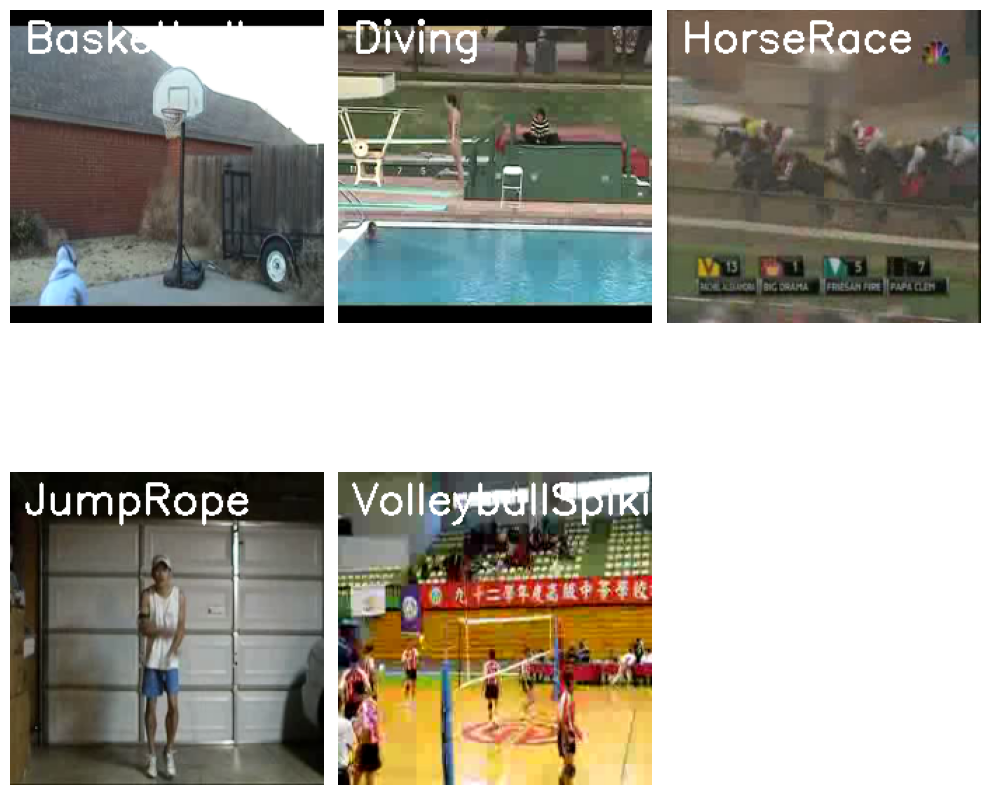

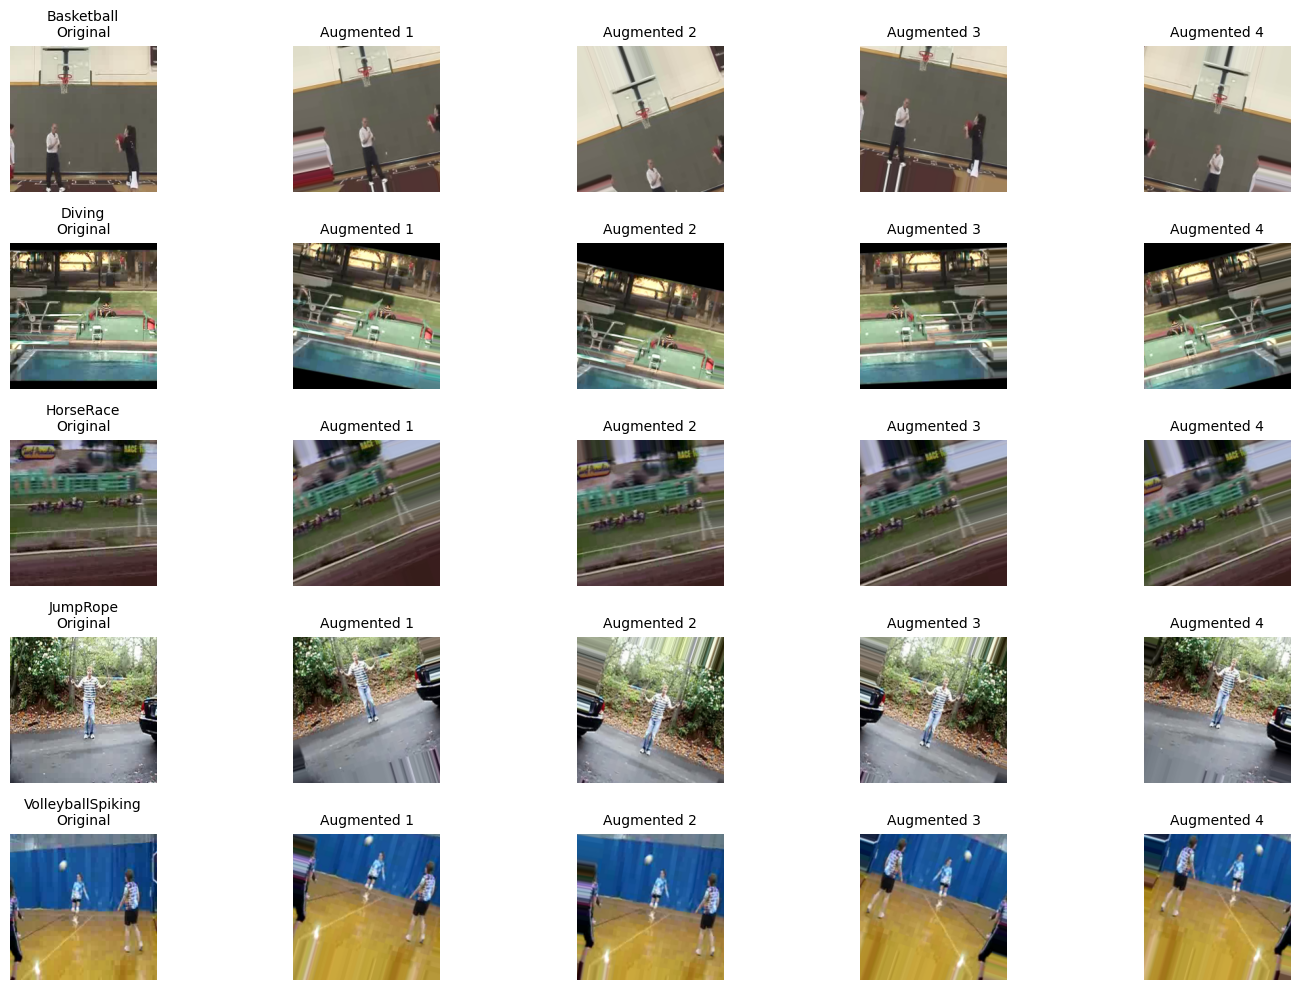

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.layers import TimeDistributed, Dropout, Flatten, Dense, LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import gc
import logging
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Define classes
classes = ["Basketball", "Diving", "HorseRace", "JumpRope", "VolleyballSpiking"]

# Check dataset balance
for class_name in classes:
    files = os.listdir(f'/kaggle/input/realistic-action-recognition-ucf50/UCF50/{class_name}')
    logging.info(f"{class_name}: {len(files)} videos")

# Visualize sample frames
plt.figure(figsize=(10, 10))
for counter, selected_class_name in enumerate(classes, 1):
    video_files_names_list = os.listdir(f'/kaggle/input/realistic-action-recognition-ucf50/UCF50/{selected_class_name}')
    selected_video_file_name = random.choice(video_files_names_list)
    video_reader = cv2.VideoCapture(f'/kaggle/input/realistic-action-recognition-ucf50/UCF50/{selected_class_name}/{selected_video_file_name}')
    _, bgr_frame = video_reader.read()
    if bgr_frame is None:
        logging.warning(f"Failed to read frame from {selected_class_name}/{selected_video_file_name}")
        continue
    bgr_frame = cv2.resize(bgr_frame, (224, 224))
    video_reader.release()
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)
    plt.subplot(2, 3, counter)
    plt.imshow(rgb_frame)
    cv2.putText(rgb_frame, selected_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.imshow(rgb_frame)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Visualize augmented frames
def extract_single_frame(video_path):
    video_reader = cv2.VideoCapture(video_path)
    if not video_reader.isOpened():
        logging.error(f"Failed to open video: {video_path}")
        return None
    success, frame = video_reader.read()
    video_reader.release()
    if not success:
        logging.warning(f"Failed to read frame from {video_path}")
        return None
    frame = cv2.resize(frame, (224, 224))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return frame

def plot_augmented_frames():
    num_augmentations = 4
    plt.figure(figsize=(15, 10))
    datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True, fill_mode='nearest')
    
    for class_idx, class_name in enumerate(classes, 1):
        video_files = os.listdir(f'/kaggle/input/realistic-action-recognition-ucf50/UCF50/{class_name}')
        if not video_files:
            logging.warning(f"No videos found for class {class_name}")
            continue
        selected_video = random.choice(video_files)
        video_path = f'/kaggle/input/realistic-action-recognition-ucf50/UCF50/{class_name}/{selected_video}'
        
        frame = extract_single_frame(video_path)
        if frame is None:
            continue
        
        plt.subplot(len(classes), num_augmentations + 1, (class_idx - 1) * (num_augmentations + 1) + 1)
        plt.imshow(frame)
        plt.title(f"{class_name}\nOriginal", fontsize=10)
        plt.axis('off')
        
        frame_for_aug = frame.astype(np.float32) / 255.0
        frame_for_aug = np.expand_dims(frame_for_aug, axis=0)
        for aug_idx in range(num_augmentations):
            aug_iter = datagen.flow(frame_for_aug, batch_size=1)
            aug_frame = next(aug_iter)[0]
            aug_frame = (aug_frame * 255).astype(np.uint8)
            plt.subplot(len(classes), num_augmentations + 1, (class_idx - 1) * (num_augmentations + 1) + aug_idx + 2)
            plt.imshow(aug_frame)
            plt.title(f"Augmented {aug_idx + 1}", fontsize=10)
            plt.axis('off')
        
        del frame, frame_for_aug, aug_frame
        gc.collect()
    
    plt.tight_layout()
    plt.show()
    logging.info("Augmented frames visualization completed")

plot_augmented_frames()

sequence_length = 15

# Data augmentation (same as above)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)